In [1]:
import os
import sys

import sys
sys.path.append('../')  # Adding the core library

from maze.models import EfficientUNet
from maze.datasets import FishHeatmapDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Dataset

Create a construct which loads the data based in COCO format, with additional heatmaps stored separately, with same naming as the source image.

In [2]:
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Preload the data

We preload the data into DDR memory, as its not so big, and it speeds up the training process massively.

In [3]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    background_dir='../data/training/background/',
    background_prob=0.3,
    joint_transform=joint_train,
    img_transform=img_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    background_dir='../data/training/background/',
    background_prob=0.3,
    joint_transform=joint_val,
    img_transform=img_transform,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

Loaded 5493 samples after excluding 0 flagged samples.
Adding 321 background samples from 321 available files.
Loaded 611 samples after excluding 0 flagged samples.
Adding 183 background samples from 321 available files.


# Trainig

Let's setup our loss, optimizer etc.
1. **Loss**: we use Mean Squared Error (MSE) between predicted heatmap and target. It's simple and works well since both are smooth distribution
2. **Optimizer**: AdamW 
3. **LR scheduler**: ReduceLROnPlateau 

Later we run the training loop. 

In [4]:
# 1. Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. Initialize the model
model = EfficientUNet()

# Freeze first 3 stages of the encoder (enc1 to enc3)
for param in model.enc1.parameters():
    param.requires_grad = False
for param in model.enc2.parameters():
    param.requires_grad = False
for param in model.enc3.parameters():
    param.requires_grad = False

model = model.to(device)

# 3. Loss setup
loss_fn = torch.nn.MSELoss()
alpha = 1.0

def get_centroid(heatmap):
    if heatmap.sum() < 1e-8:
        return None

    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w

    confidence = heatmap[torch.arange(b), 0, y, x]  # shape: [B]

    return x.float(), y.float(), confidence.float()

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.sum().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(pred)
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

# 4. Optimizer & scheduler (unchanged)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Using device: cuda


In [5]:
# 5. Training Loop Setup
epochs = 40
epoch_save_interval = 5

model_dir = '../data/models/efficientunet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
# 6. Training Loop
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_cdist_loss = 0.0
    cdist_num = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for imgs, heatmaps in train_bar:
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)
        
        mse = loss_fn(preds, heatmaps)
        cdist, distances = centroid_distance_loss(preds, heatmaps)
        loss = mse + alpha * cdist

        if distances > 0:
            train_cdist_loss += cdist.item() * distances
            cdist_num += distances

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        train_bar.set_postfix(mse=mse.item())

    train_loss /= len(train_loader)

    if cdist_num > 0:
        train_cdist_loss /= cdist_num

    model.eval()
    val_loss = 0.0
    val_cdist_loss = 0.0
    cdist_num = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    with torch.no_grad():
        for imgs, heatmaps in val_bar:
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)

            mse = loss_fn(preds, heatmaps)
            cdist, distances = centroid_distance_loss(preds, heatmaps)
            loss = mse + alpha * cdist

            if distances > 0:
                val_cdist_loss += cdist.item() * distances
                cdist_num += distances

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            val_bar.set_postfix(mse=mse.item())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if cdist_num > 0:
        val_cdist_loss /= cdist_num

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train CDist = {train_cdist_loss:.4f} Val Loss = {val_loss:.4f}, Val CDist = {val_cdist_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    # Save model checkpoint every N epochs
    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epoch 1/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: Train Loss = 120.0398, Train CDist = 119.8859 Val Loss = 152.3038, Val CDist = 152.1194


Epoch 2/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: Train Loss = 127.7356, Train CDist = 127.8309 Val Loss = 117.9959, Val CDist = 117.7984


Epoch 3/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: Train Loss = 85.9730, Train CDist = 86.1151 Val Loss = 49.2795, Val CDist = 49.0432


Epoch 4/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: Train Loss = 54.2114, Train CDist = 54.2877 Val Loss = 28.7969, Val CDist = 28.7426


Epoch 5/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: Train Loss = 42.2113, Train CDist = 42.2780 Val Loss = 19.1818, Val CDist = 19.2587


Epoch 6/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6: Train Loss = 35.8138, Train CDist = 35.9237 Val Loss = 13.6621, Val CDist = 13.6729


Epoch 7/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7: Train Loss = 30.7974, Train CDist = 30.9023 Val Loss = 12.4309, Val CDist = 12.4595


Epoch 8/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8: Train Loss = 28.3670, Train CDist = 28.3577 Val Loss = 11.6902, Val CDist = 11.6422


Epoch 9/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9: Train Loss = 26.6525, Train CDist = 26.6274 Val Loss = 11.1217, Val CDist = 11.0721


Epoch 10/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 10/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10: Train Loss = 23.7222, Train CDist = 23.8191 Val Loss = 10.6175, Val CDist = 10.5963


Epoch 11/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 11/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11: Train Loss = 24.0997, Train CDist = 24.0923 Val Loss = 9.8616, Val CDist = 9.8241


Epoch 12/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 12/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12: Train Loss = 22.7326, Train CDist = 22.7157 Val Loss = 9.9778, Val CDist = 9.9176


Epoch 13/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 13/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13: Train Loss = 21.1393, Train CDist = 21.1906 Val Loss = 9.5667, Val CDist = 9.5508


Epoch 14/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 14/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14: Train Loss = 20.8665, Train CDist = 20.8591 Val Loss = 9.6687, Val CDist = 9.6952


Epoch 15/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 15/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15: Train Loss = 19.5399, Train CDist = 19.5834 Val Loss = 9.2837, Val CDist = 9.3195


Epoch 16/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 16/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16: Train Loss = 19.0724, Train CDist = 19.1040 Val Loss = 9.1528, Val CDist = 9.1746


Epoch 17/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 17/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17: Train Loss = 18.6999, Train CDist = 18.7215 Val Loss = 9.1836, Val CDist = 9.1710


Epoch 18/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 18/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18: Train Loss = 18.1056, Train CDist = 18.0905 Val Loss = 9.0823, Val CDist = 9.1188


Epoch 19/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 19/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19: Train Loss = 19.4260, Train CDist = 19.4121 Val Loss = 8.9236, Val CDist = 8.9366


Epoch 20/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 20/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20: Train Loss = 16.5891, Train CDist = 16.5815 Val Loss = 8.5672, Val CDist = 8.6139


Epoch 21/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 21/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21: Train Loss = 17.7668, Train CDist = 17.7907 Val Loss = 8.5239, Val CDist = 8.5141


Epoch 22/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 22/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22: Train Loss = 16.7571, Train CDist = 16.7231 Val Loss = 8.2467, Val CDist = 8.2326


Epoch 23/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 23/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23: Train Loss = 16.7974, Train CDist = 16.7772 Val Loss = 8.3926, Val CDist = 8.3910


Epoch 24/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 24/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24: Train Loss = 16.2724, Train CDist = 16.2680 Val Loss = 8.1756, Val CDist = 8.1847


Epoch 25/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 25/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25: Train Loss = 16.4356, Train CDist = 16.4413 Val Loss = 8.1050, Val CDist = 8.1193


Epoch 26/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 26/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26: Train Loss = 15.2758, Train CDist = 15.2568 Val Loss = 8.0829, Val CDist = 8.0955


Epoch 27/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 27/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27: Train Loss = 15.0225, Train CDist = 15.0298 Val Loss = 7.9385, Val CDist = 7.9418


Epoch 28/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 28/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28: Train Loss = 15.1451, Train CDist = 15.1596 Val Loss = 7.4949, Val CDist = 7.5041


Epoch 29/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 29/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29: Train Loss = 14.2492, Train CDist = 14.2331 Val Loss = 7.6497, Val CDist = 7.6498


Epoch 30/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 30/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30: Train Loss = 14.1847, Train CDist = 14.1991 Val Loss = 7.2239, Val CDist = 7.2171


Epoch 31/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 31/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31: Train Loss = 14.2673, Train CDist = 14.2774 Val Loss = 7.6136, Val CDist = 7.5770


Epoch 32/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 32/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32: Train Loss = 13.1468, Train CDist = 13.1451 Val Loss = 7.1259, Val CDist = 7.1089


Epoch 33/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 33/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33: Train Loss = 13.9096, Train CDist = 13.9006 Val Loss = 7.0227, Val CDist = 7.0262


Epoch 34/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 34/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 34: Train Loss = 13.5521, Train CDist = 13.5644 Val Loss = 7.0100, Val CDist = 7.0360


Epoch 35/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 35/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35: Train Loss = 13.1041, Train CDist = 13.0820 Val Loss = 6.9266, Val CDist = 6.9603


Epoch 36/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 36/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36: Train Loss = 12.4939, Train CDist = 12.4881 Val Loss = 7.1562, Val CDist = 7.1853


Epoch 37/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 37/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37: Train Loss = 12.5700, Train CDist = 12.5616 Val Loss = 6.6327, Val CDist = 6.6477


Epoch 38/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 38/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 38: Train Loss = 12.6381, Train CDist = 12.6617 Val Loss = 6.9208, Val CDist = 6.9670


Epoch 39/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 39/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39: Train Loss = 11.7718, Train CDist = 11.7838 Val Loss = 6.7626, Val CDist = 6.8010


Epoch 40/40 [Train]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 40/40 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40: Train Loss = 12.1580, Train CDist = 12.1600 Val Loss = 6.8360, Val CDist = 6.8782


# Model Validation

Now let's put model through numerous tests to see how well it performs.

In [7]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [16]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)  # make sure model includes sigmoid() if using MSE

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(imgs)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()
            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


Average centroid distance: 6.65 px, Average confidence: 0.51
Within 3px: 25.70%
Within 5px: 52.54%
Within 10px: 87.07%


In [17]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    print(f"GT Value at center: {gt_value_center:.2f}, Pred Value at center: {p_value_center:.2f}")

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()



GT Value at center: 1.00, Pred Value at center: 0.00


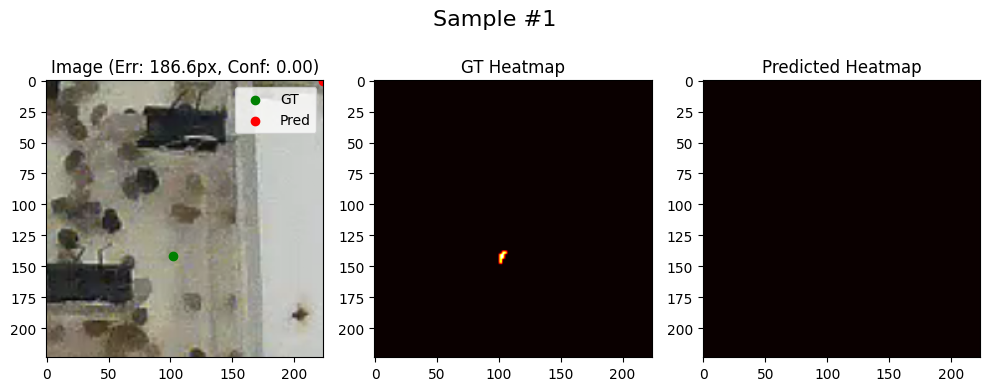

GT Value at center: 1.00, Pred Value at center: 0.00


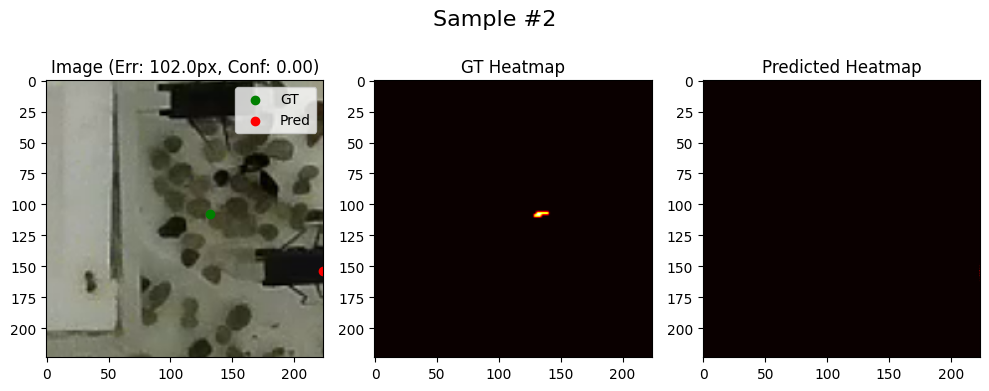

GT Value at center: 0.95, Pred Value at center: 0.48


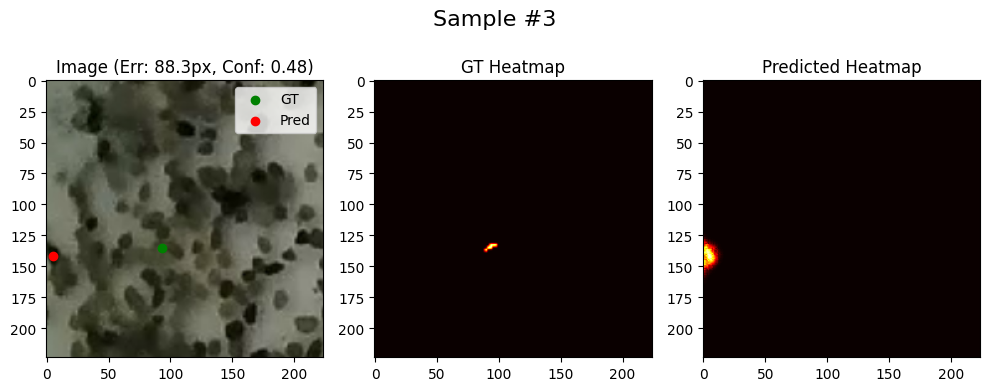

GT Value at center: 1.00, Pred Value at center: 0.52


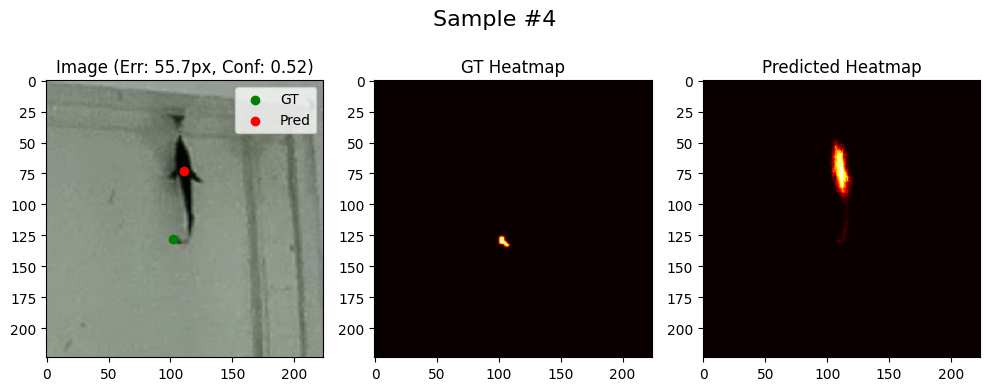

GT Value at center: 0.87, Pred Value at center: 0.52


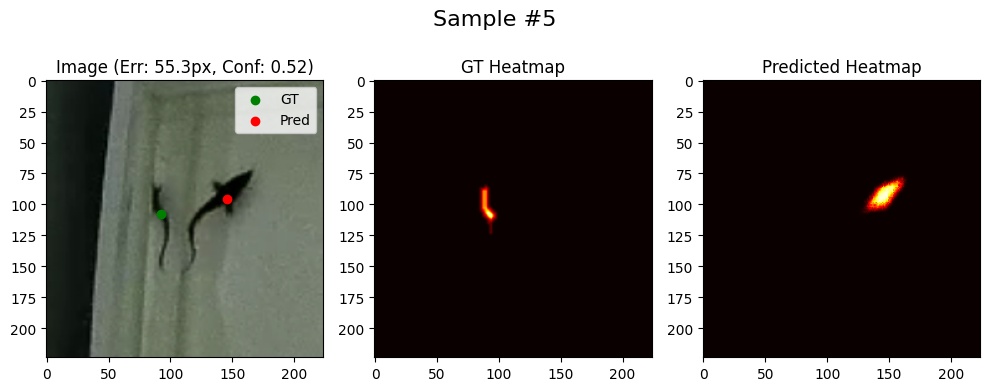

GT Value at center: 0.96, Pred Value at center: 0.46


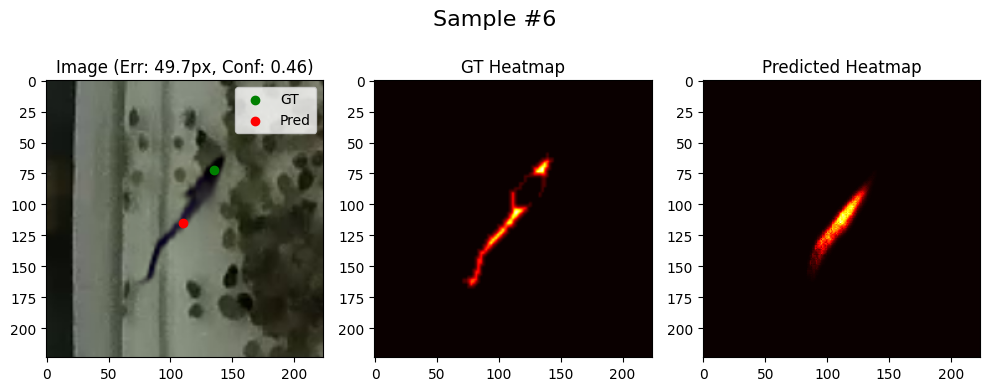

GT Value at center: 0.95, Pred Value at center: 0.00


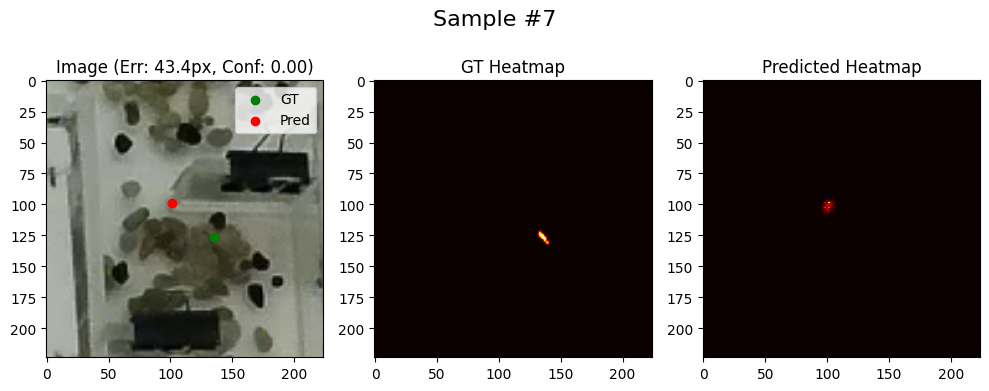

GT Value at center: 0.90, Pred Value at center: 0.50


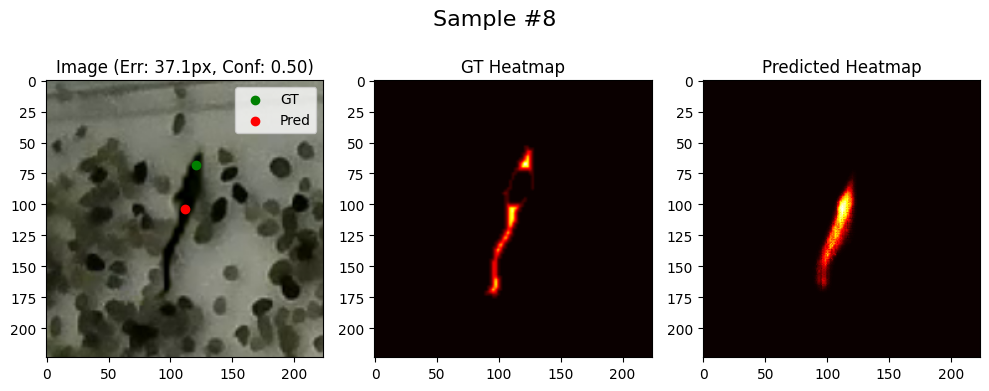

GT Value at center: 0.91, Pred Value at center: 0.50


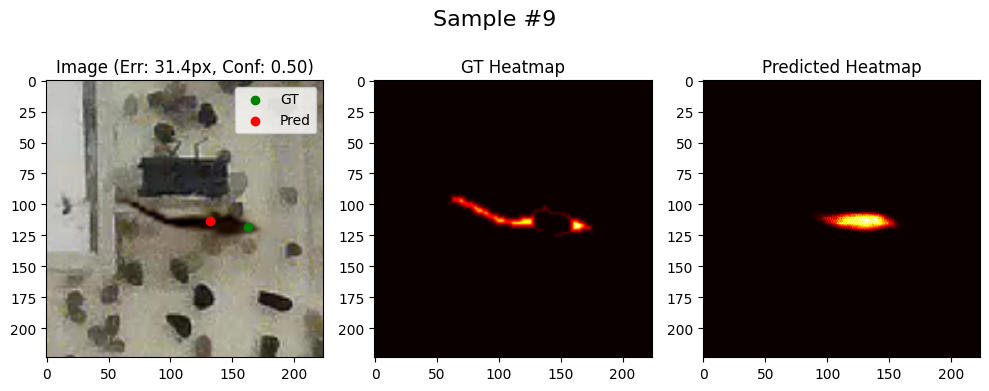

GT Value at center: 0.95, Pred Value at center: 0.45


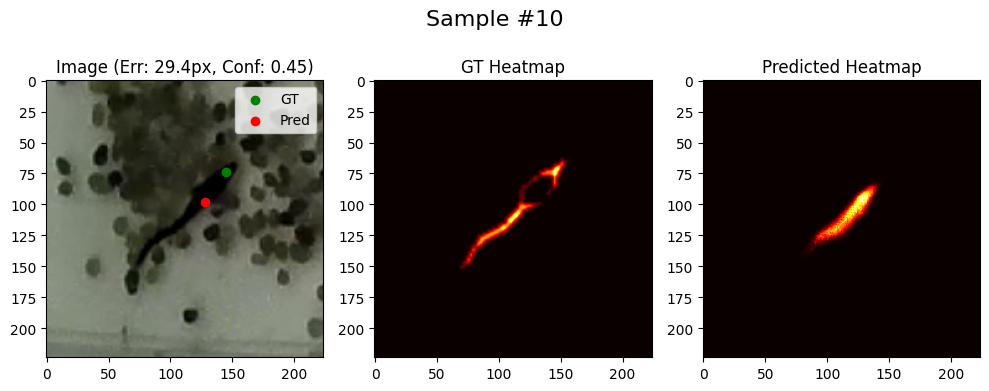

In [18]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

GT Value at center: 0.89, Pred Value at center: 0.50


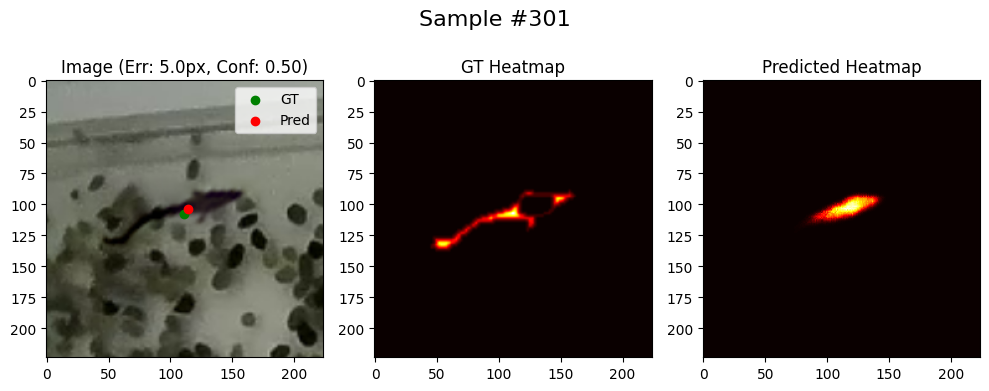

GT Value at center: 0.92, Pred Value at center: 0.53


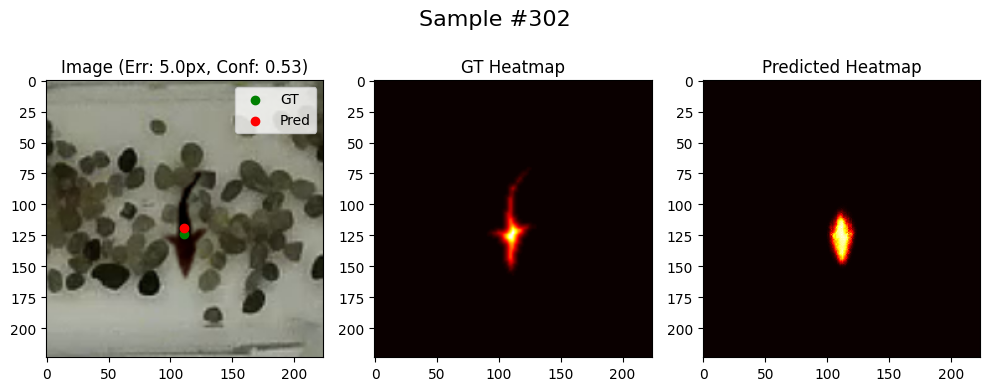

GT Value at center: 0.94, Pred Value at center: 0.53


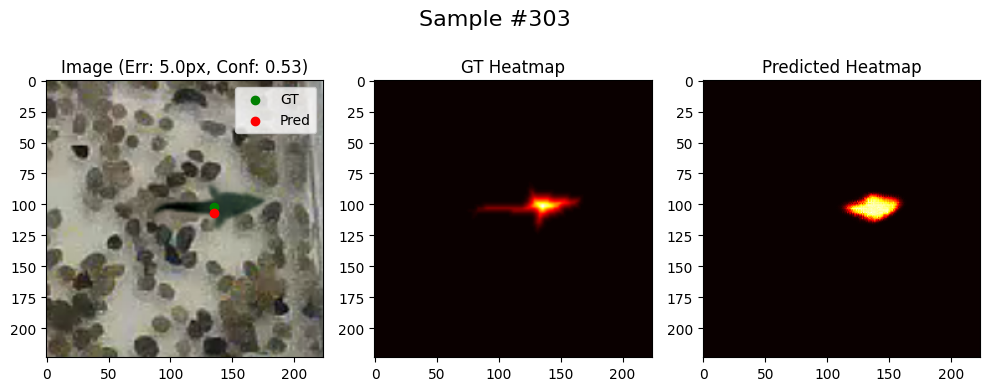

GT Value at center: 1.00, Pred Value at center: 0.51


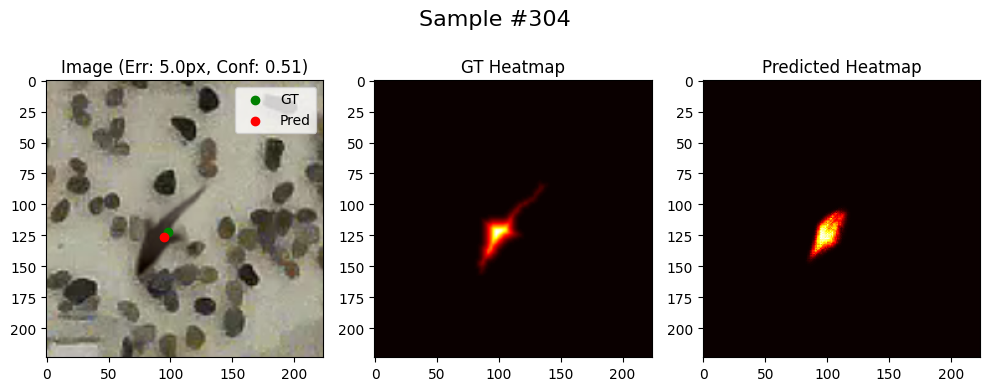

GT Value at center: 0.97, Pred Value at center: 0.51


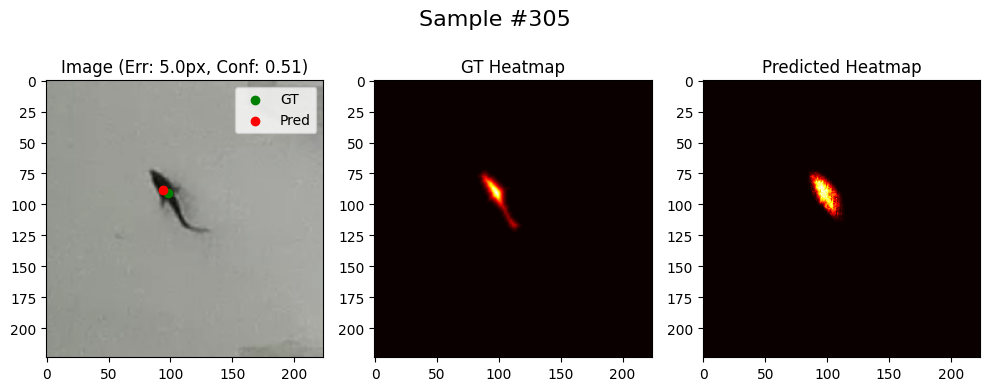

GT Value at center: 0.98, Pred Value at center: 0.52


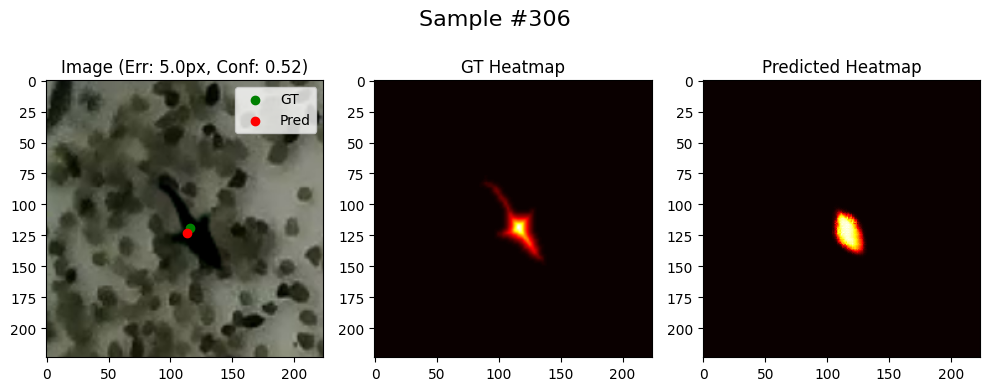

GT Value at center: 0.91, Pred Value at center: 0.49


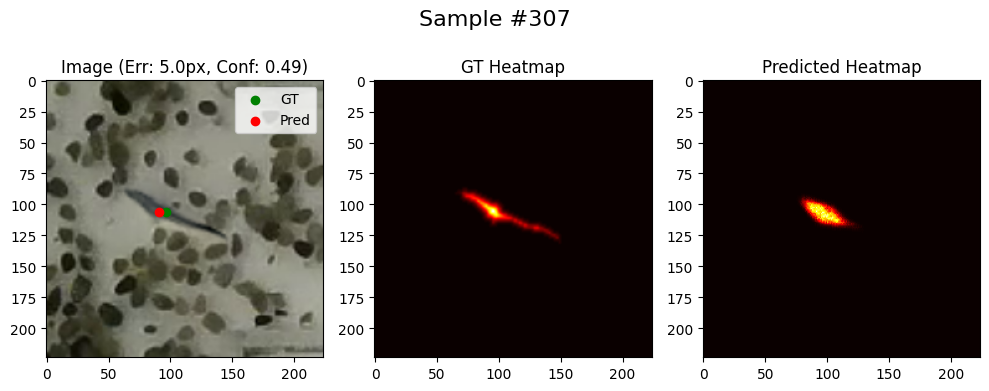

GT Value at center: 0.97, Pred Value at center: 0.51


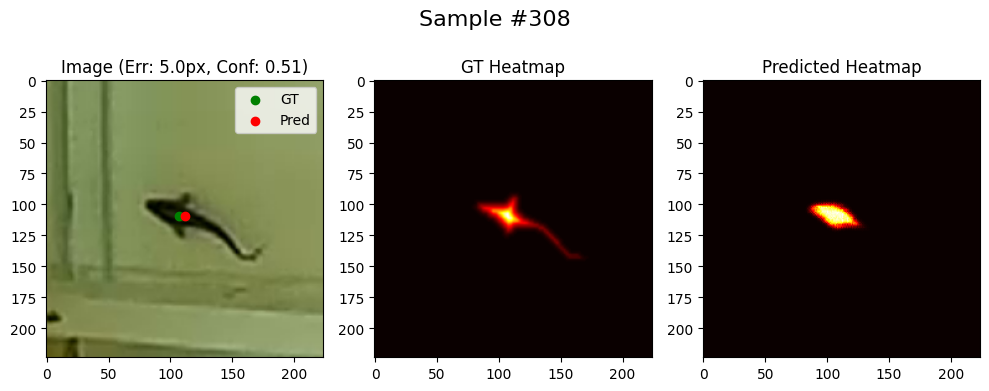

GT Value at center: 0.97, Pred Value at center: 0.47


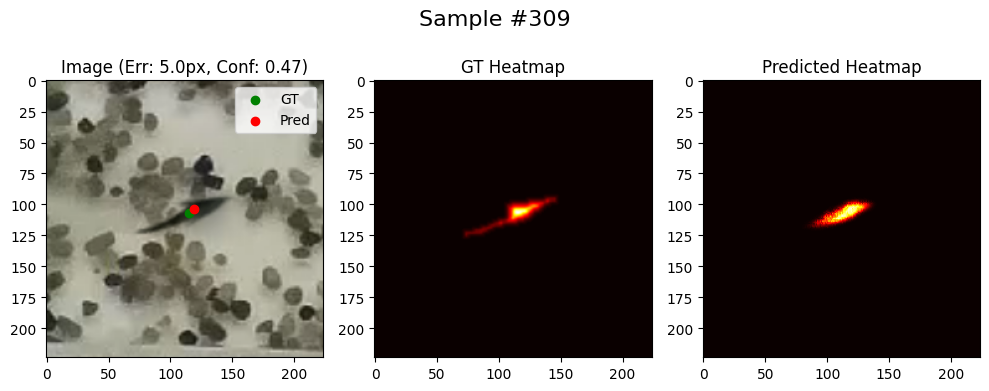

GT Value at center: 0.95, Pred Value at center: 0.50


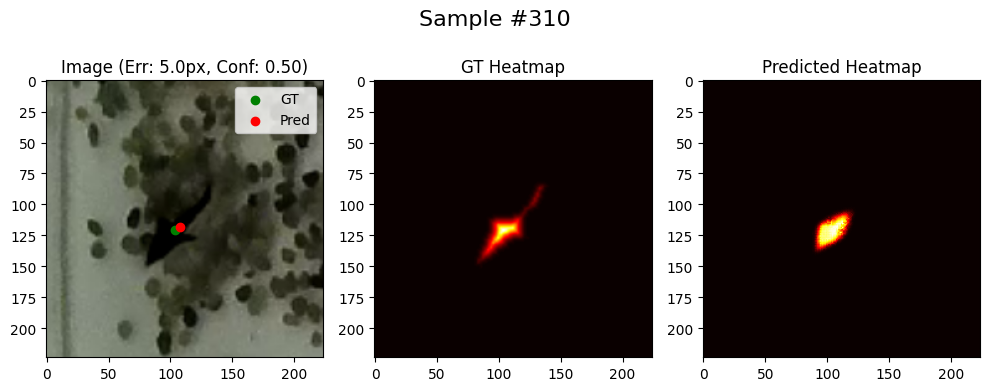

In [19]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

GT Value at center: 0.97, Pred Value at center: 0.52


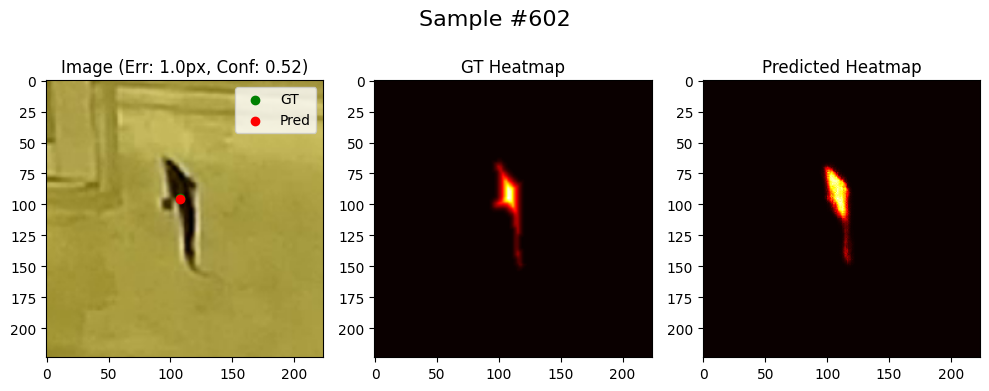

GT Value at center: 0.93, Pred Value at center: 0.53


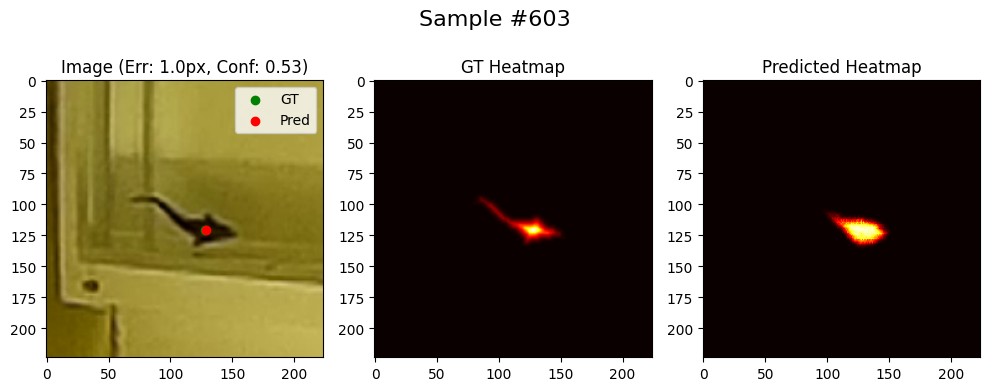

GT Value at center: 0.99, Pred Value at center: 0.50


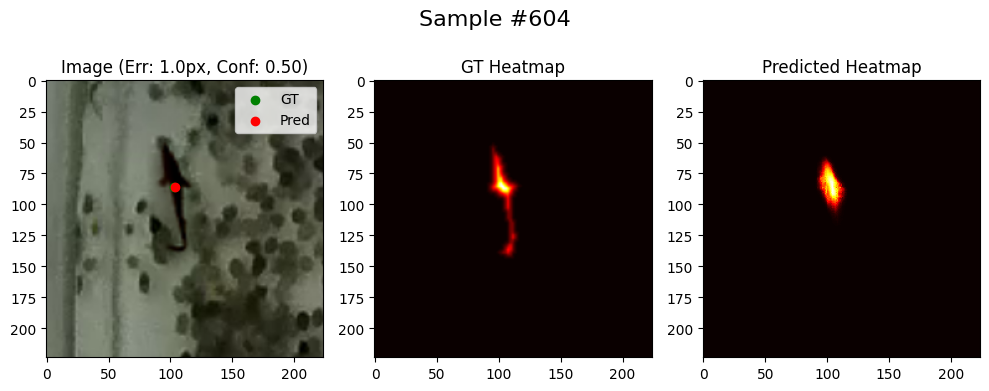

GT Value at center: 0.95, Pred Value at center: 0.53


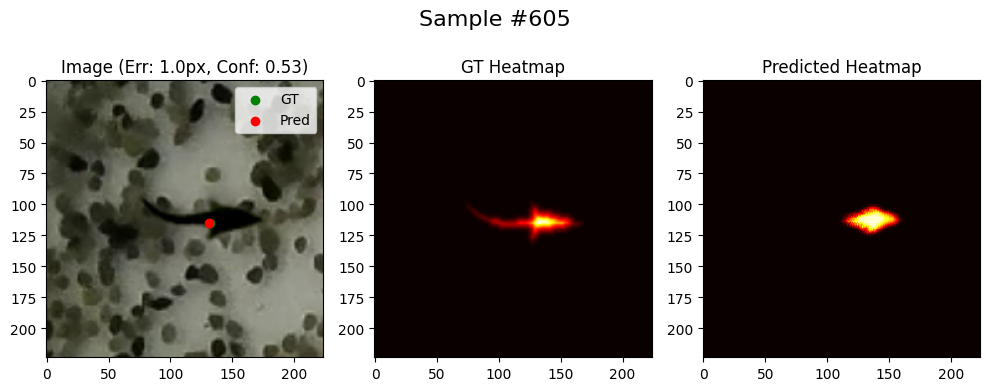

GT Value at center: 0.98, Pred Value at center: 0.52


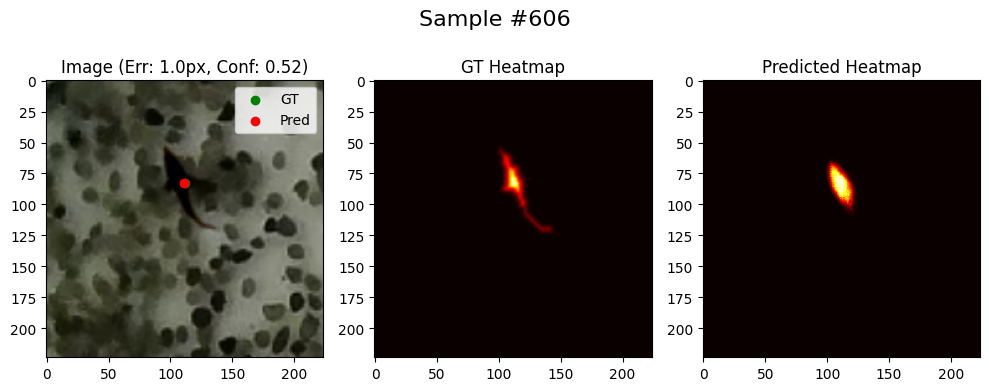

GT Value at center: 0.96, Pred Value at center: 0.49


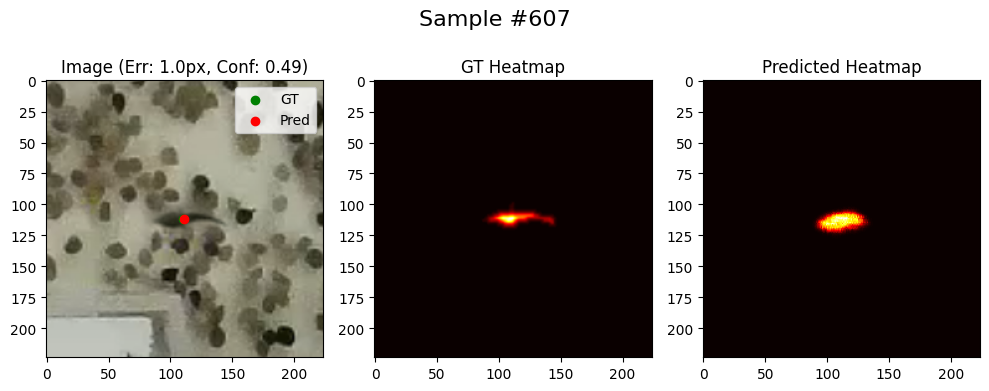

GT Value at center: 0.94, Pred Value at center: 0.52


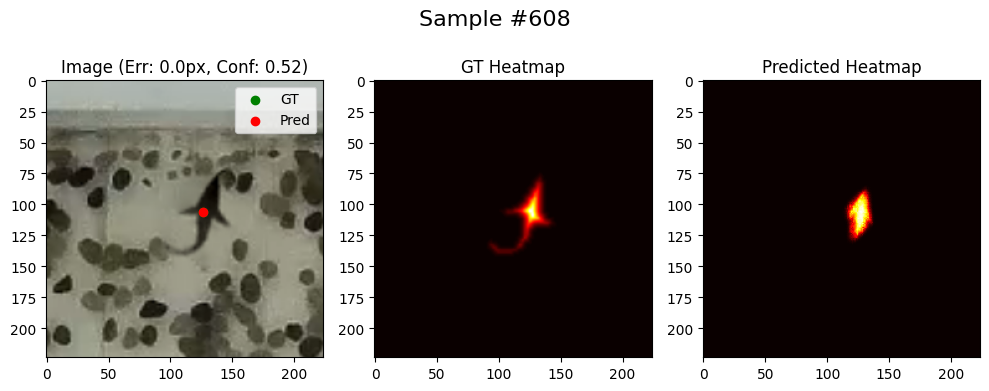

GT Value at center: 0.96, Pred Value at center: 0.54


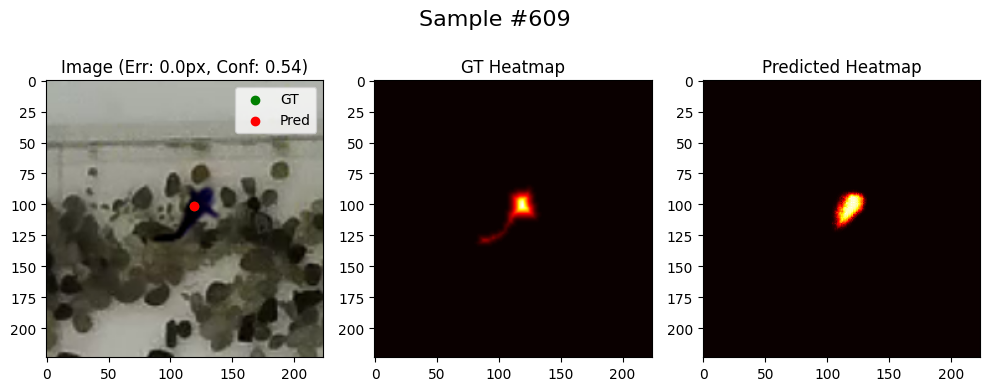

GT Value at center: 0.90, Pred Value at center: 0.53


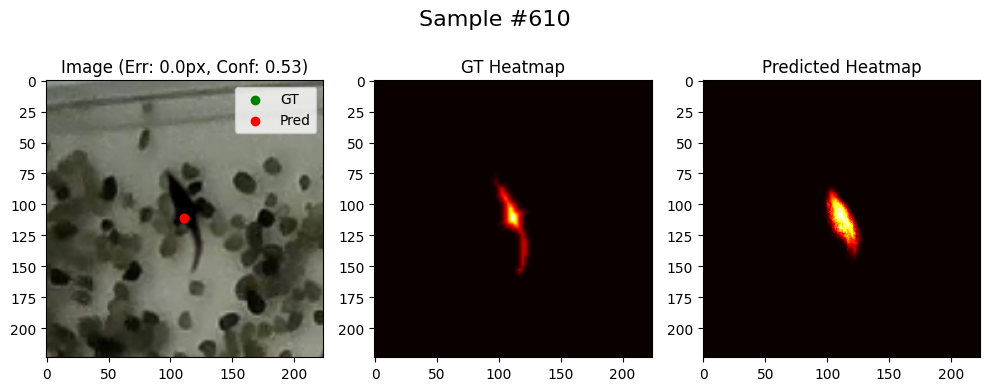

GT Value at center: 0.98, Pred Value at center: 0.52


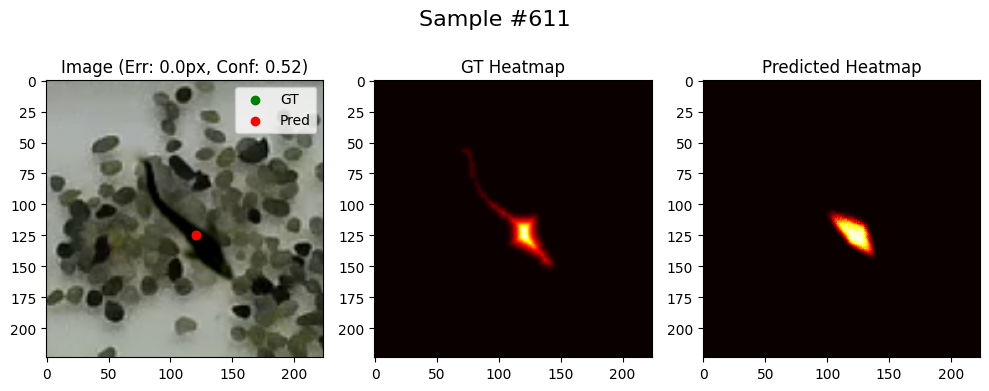

In [20]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)